In [13]:
#import dependencies 
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from datetime import datetime
from dateutil.parser import parse

In [14]:
# pulling Csv file
police = "Resources/police_data.csv"
police_df = pd.read_csv(police, encoding="ISO-8859-1")

police_df.head()
police_df.count()

Incident Number w/year     133949
Year of Incident           133949
Watch                      133949
Call (911) Problem         132683
Type of Incident           133949
Date1 of Occurrence        133949
Month1 of Occurence        133949
Day1 of the Week           133949
Time1 of Occurrence        133949
Call Dispatch Date Time    132673
X Coordinate                98503
Y Cordinate                 98503
Zip Code                   133669
City                       132123
State                      132974
dtype: int64

In [15]:
#Cleaning Data  
police_df = police_df.dropna(how='any')

police_df.count()

Incident Number w/year     95440
Year of Incident           95440
Watch                      95440
Call (911) Problem         95440
Type of Incident           95440
Date1 of Occurrence        95440
Month1 of Occurence        95440
Day1 of the Week           95440
Time1 of Occurrence        95440
Call Dispatch Date Time    95440
X Coordinate               95440
Y Cordinate                95440
Zip Code                   95440
City                       95440
State                      95440
dtype: int64

#we went with the complete data set in order to consitent an clean infromation accross the board 

In [16]:
police_df.head()

,Incident Number w/year,Year of Incident,Watch,Call (911) Problem,Type of Incident,Date1 of Occurrence,Month1 of Occurence,Day1 of the Week,Time1 of Occurrence,Call Dispatch Date Time,X Coordinate,Y Cordinate,Zip Code,City,State
205,171565-2018,2018,3,40 - OTHER,VIO PROTECT ORDER BIAS/PREJUDICE,8/4/2018,August,Sat,21:54,8/4/2018 23:30,2476498.585,6971715.153,75212.0,DALLAS,TX
212,257226-2018,2018,2,58 - ROUTINE INVESTIGATION,ABANDONED PROPERTY (NO OFFENSE),11/26/2018,November,Mon,15:20,11/30/2018 08:53,2548241.858,6932130.126,75253.0,DALLAS,TX
219,249258-2018,2018,1,7X - MAJOR ACCIDENT,PUBLIC INTOXICATION,11/18/2018,November,Sun,00:25,11/18/2018 00:39,2525365.155,6960102.895,75217.0,DALLAS,TX
221,279186-2018,2018,2,16 - INJURED PERSON,ASSAULT -BODILY INJURY ONLY,12/31/2018,December,Mon,14:00,12/31/2018 15:20,2496126.907,6941940.628,75216.0,DALLAS,TX
222,209518-2018,2018,2,55 - TRAFFIC STOP,WARRANT-DALLAS PD (ALIAS/CAPIAS),9/21/2018,September,Fri,08:48,9/21/2018 08:48,2487800.730,6937829.316,75216.0,DALLAS,TX


In [17]:
#pulling the time of distpatch 
dispatch_time_split = police_df['Call Dispatch Date Time'].str.split(expand=True)
dispatch_time = dispatch_time_split[1]


#pullign the tiem that the incident occured (to compare the difference)
incident_time = police_df['Time1 of Occurrence']
# average_dispatch_time= dispatch_time - incident_time
#dispatch_time


In [18]:
#convert time into leteral quantitative time 
dispatch_time_conversion = [datetime.strptime(x, '%H:%M') for x in dispatch_time]
incident_time_conversion = [datetime.strptime(x, '%H:%M') for x in incident_time]

In [19]:
#find out how many incidents occured within which watch (split between times of the day)
watch_count = police_df.groupby('Watch')['Incident Number w/year'].count()
watch_count

Watch
1    32613
2    28896
3    33931
Name: Incident Number w/year, dtype: int64

In [20]:
# Obtain the x and y coordinates for each of the three watch types

watch1_df = police_df.loc[police_df['Watch'] == "1"]
watch1_count = watch1_df['Incident Number w/year'].count()
watch1_count

#then for each one you want to group by the city, then do the math (mean, sum, etc) 
#watch one incedidents per year count 
#urb_fa = urban_cities["fare"].mean() 

#R.R.

# plt.scatter(x=w_1, y=w1_yr, s=ibt_w1, facecolor="yellow", edgecolor="black",alpha=.8, label="Watch One")
# plt.scatter(x=w_2, y=w2_yr, s=ibt_w1, facecolor="green", edgecolor="black",alpha=.8, label="Watch Two")
# plt.scatter(x=w_3, y=w3_yr, s=ibt_w1, facecolor="blue", edgecolor="black",alpha=.8, label="Watch Three")


# plt.grid()


# #Create a legend
# #Incorporate a text label regarding circle size
# plt.title("Incidents Per Watch over Year")
# plt.xlabel("Different Watches")
# plt.ylabel("Number of Incidents")
# plt.legend(loc="best")



####Do we want to incoporporate the "type" of incidetn as "s" value or maintain the two, because then a bar chart makes most sense for the particular up above data 

0

In [21]:
#pulling the type of "crime" that is being called in and the count to the type of crime 
#police_df['Call (911) Problem'].value_counts()

In [22]:
police_df['Call (911) Problem'] = police_df['Call (911) Problem'].replace(
    {'09 - THEFT': 'THEFT',
    '09/01 - THEFT' : 'THEFT',
    'PSE/09 - THEFT': 'THEFT', 
    '20 - ROBBERY' : 'ROBBERY', 
    '20R - ROBBERY (REPORT)+1HR': 'ROBBERY',
    '12B - BUSINESS ALARM' : 'ALARMS_DISTURBANCE',
    '12N - BURGLAR ALARM NONDISP': 'ALARMS_DISTURBANCE', 
    '12R - RESIDENTIAL ALARM': 'ALARMS_DISTURBANCE',
    '21R - RES PANIC  ALARM': 'ALARMS_DISTURBANCE', 
    '6XE - DISTURBANCE EMERGENCY': 'ALARMS_DISTURBANCE',
    'ARSON -ALL OTHERS': 'ALARMS_DISTURBANCE', 
    '6XA - MAJOR DIST  AMBULANCE': 'ALARMS_DISTURBANCE',
    '6XEA - DISTURBANCE EMERG AMB': 'ALARMS_DISTURBANCE', 
    '6M - LOUD MUSIC DISTURBANCE': 'ALARMS_DISTURBANCE',
    "6X/01 WOMEN'S SHELTER DIST": 'ALARMS_DISTURBANCE',
    '22 - ANIMAL DISTURBANCE' : 'ALARMS_DISTURBANCE',
    '12 - BURGLAR ALARM UNKNOWN' : 'ALARMS_DISTURBANCE',
    '15 - ASSIST OFFICER': 'ASSISTING_OFFICER', 
    '15A - ASSIST OFFICER W/AMB': 'ASSISTING_OFFICER',
    '14 - STABBING, CUTTING': 'INJURY', 
    '16 - INJURED PERSON': 'INJURY',
    '16A - INJURED PERSON W/AMB': 'INJURY', 
    '11B - BURG OF BUS' : 'BURGLARY',
    '11B/01 - BURG OF BUS': 'BURGLARY',
    '11C - BURG COIN OPER' : 'BURGLARY',
    '11C/01 - BURG COIN OPER' : 'BURGLARY',
    '11R - BURG OF RES' : 'BURGLARY',
    '11R/01 - BURG OF RES' : 'BURGLARY',
    '11V - BURG MOTOR VEH' : 'BURGLARY',
    '11V/01 - BURG MOTOR VEH' : 'BURGLARY',
    'PSE/11B - BURG OF BUS' : 'BURGLARY',
    'PSE/11C -  BURG COIN OP' : 'BURGLARY',
    'PSE/11R - BURG OF RES' : 'BURGLARY',
    'PSE/11V - BURG MOTOR VEH' : 'BURGLARY',
    '18 - STRUCTURE FIRE' : 'FIRE',
    '18A - VEHICLE FIRE' : 'FIRE',
    '**PD REQUESTED BY FIRE' : 'FIRE',
    'SIP - SLEEPING IN PUBLIC' : 'MINOR_OFFENSES',
    '06 - MINOR DISTURBANCE' : 'MINOR_OFFENSES',
    'PH - PANHANDLER' : 'MINOR_OFFENSES',
    'PSE/11R - BURG OF RES' : 'BURGLARY',
    'PSE/11V - BURG MOTOR VEH' : 'BURGLARY',
    'TOW - TOWREPO' : 'VEHICLE_VIOLATIONS',
    '23 - PARKING VIOLATION' : 'VEHICLE_VIOLATIONS',
    'PK - PARK CHECK' : 'VEHICLE_VIOLATIONS',
    '55 - TRAFFIC STOP' : 'VEHICLE_VIOLATIONS',
    'BCA - BAIT CAR ACTIVATION' : 'VEHICLE_VIOLATIONS',
    '09V - UUMV' : 'VEHICLE_VIOLATIONS',
    '09V-01 UUMV JUST OCRD' : 'VEHICLE_VIOLATIONS',
    '43 - ROAD RAGE' : 'VEHICLE_VIOLATIONS',
    '37 - STREET BLOCKAGE' : 'VEHICLE_VIOLATIONS',
    '37F - FREEWAY BLOCKAGE' : 'VEHICLE_VIOLATIONS',
    '39 - SPEEDING/RACING' : 'VEHICLE_VIOLATIONS',
    'PSE/09V - UUMV' : 'VEHICLE_VIOLATIONS',
    'DH - DRUG HOUSE' : 'DRUG_RELATED',
    'OADS - OPEN AIR DRUG SALES' : 'DRUG_RELATED',
    'DAEF-DIST ARMED ENCOUNTER FOOT' : 'ARMED_OFFENSE',
    'DAEV-DIST ARMED ENCOUNTER VEH' : 'ARMED_OFFENSE',
    'DASF-DIST ACTIVE SHOOTER FOOT' : 'ARMED_OFFENSE',
    'DASV-DIST ACTIVE SHOOTER VEH' : 'ARMED_OFFENSE',
    '6G - RANDOM GUN FIRE' : 'ARMED_OFFENSE',
    '19 - SHOOTING' : 'ARMED_OFFENSE',
    '21B - BUSINESS HOLD UP' : 'ARMED_OFFENSE',
    '28 - OPEN CARRY' : 'ARMED_OFFENSE',
    'AC - ANIMAL CRUELTY' : 'ANIMAL_CRUELTY',
    'AC/01 - ANIMAL CRUELTY IN PROG' : 'ANIMAL_CRUELTY',    
    '22A - ANIMAL ATTACK' : 'ANIMAL_CRUELTY',
    '41/09 - THEFT - IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/09V  - UUMV IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/11B - BURG BUSN IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/11R - BURG RES IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/11V - BMV-IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/20 - ROBBERY - IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/25 - CRIMINAL ASLT -IN PROG' : 'CRIME_IN_PROGRESS',
    '41/31 - CRIM MIS/PROGRESS/FELO' : 'CRIME_IN_PROGRESS',
    '41/40 - OTHER - IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '25 - CRIMINAL ASSAULT' : 'CRIME_IN_PROGRESS',
    '42 - CHASE' : 'POLICE_CHASE',
    '42FP - FOOT PURSUIT' : 'POLICE_CHASE',
    '31/01 - CRIM MIS/PROG/NON FELO' : 'CRIMINAL_MISCONDUCT',
    '30 - PRISONER' : 'OTHER',
    '30/01 - ODO W/PRISONER' : 'OTHER',
    '30D - PRISONER OTHER AGENCY' : 'OTHER',
    '36/01 - ABAND CHILD CRITICAL' : 'ABANDONMENT',
    '24 - ABANDONED PROPERTY' : 'ABANDONMENT',
    '29 - OPEN BUILDING' : 'ABANDONMENT',
    '33 - PROSTITUTION' : 'PROSTITUTION',
    'PSE/40 - OTHER' : 'OTHER',
    'WIC - WALK IN CASE' : 'OTHER',
    '04 - 911 HANG UP' : 'OTHER',
    'ODJ - OFF DUTY JOB' : 'OTHER',
    '40 - OTHER' : 'OTHER',
    'WIC - WALK IN CASE #' : 'OTHER',
    '40/01 - OTHER' : 'OTHER',
    '76 - WARRANT SERVICE' : 'OTHER',
    'PSE/24 - LOST PROPERTY' : 'OTHER',
    '08 - INTOXICATED PERSON' : 'OTHER',
    '38 - MEET COMPLAINANT' : 'OTHER',
    '70 - ETS ACTIVATION' : 'OTHER',
    '7X - MAJOR ACCIDENT' : 'ACCIDENT',
    '7CE - CITY EQUIPMENT ACCIDENT' : 'ACCIDENT',
    '7XCE - MAJOR ACC CITY EQUIP' : 'ACCIDENT',
    '7XF - MAJOR ACCIDENT FREEWAY' : 'ACCIDENT',
    '7XFCE - MAJOR ACC FWY CITY EQ' : 'ACCIDENT',
    '07 - MINOR ACCIDENT' : 'ACCIDENT',
    '6S - SCHOOL DIST (VIOLENCE)' : 'VIOLENCE',
    '6X - MAJOR DIST (VIOLENCE)' : 'VIOLENCE',
    '25 - CRIMINAL ASSAULT ' : 'VIOLENCE',
    '17 - KIDNAPPING IN PROGRESS' : 'MISSING_PERSONS',
    '17C - CHILD ABDUCTION' : 'MISSING_PERSONS',
    '26 - MISSING PERSON' : 'MISSING_PERSONS',
    'PSE/26 - MISSING PERSON' : 'MISSING_PERSONS',
    '26/01- MISSING PERSON-CRITICAL' : 'MISSING_PERSONS',
    '58 - ROUTINE INVESTIGATION' : 'SUSPICIOUS_PERSON',
    'PSE/31- CRIMINAL MISCHIEF' : 'SUSPICIOUS_PERSON',
    '31 - CRIMINAL MISCHIEF' : 'SUSPICIOUS_PERSON',
    '13 - PROWLER' : 'SUSPICIOUS_PERSON',
    '32 - SUSPICIOUS PERSON' : 'SUSPICIOUS_PERSON',
    '34 - SUICIDE' : 'SUICIDE/DEATH',
    '27 - DEAD PERSON' : 'SUICIDE/DEATH',
    '46 - CIT' : 'CRISIS_INTERVENTION',
    '46A - CIT W/AMBULANCE' : 'CRISIS_INTERVENTION',
    '44 - PERSON IN DANGER HIGH WTR' : 'CRISIS_INTERVENTION',
    '34 - SUICIDE' : 'CRISIS_INTERVENTION'})
calls = police_df['Call (911) Problem'].value_counts()
#calls


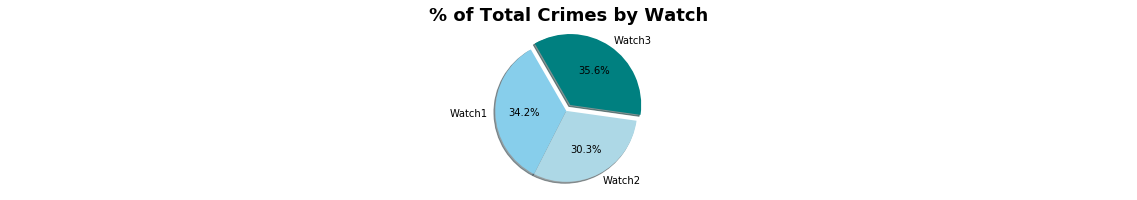

In [31]:
total_crimes_by_watch= police_df.groupby('Watch')['Incident Number w/year'].count()
type_labels = 'Watch1', 'Watch2', 'Watch3'
colors = ['skyblue', 'lightblue', 'teal']
explode = [.0,.0,.1]
plt.pie(total_crimes_by_watch, labels= type_labels, colors= colors,
autopct='%1.1f%%', shadow=True, explode=explode, startangle=120)
plt.title('% of Total Crimes by Watch', fontsize = 18, fontweight='bold') 
plt.axis("equal")
plt.show()

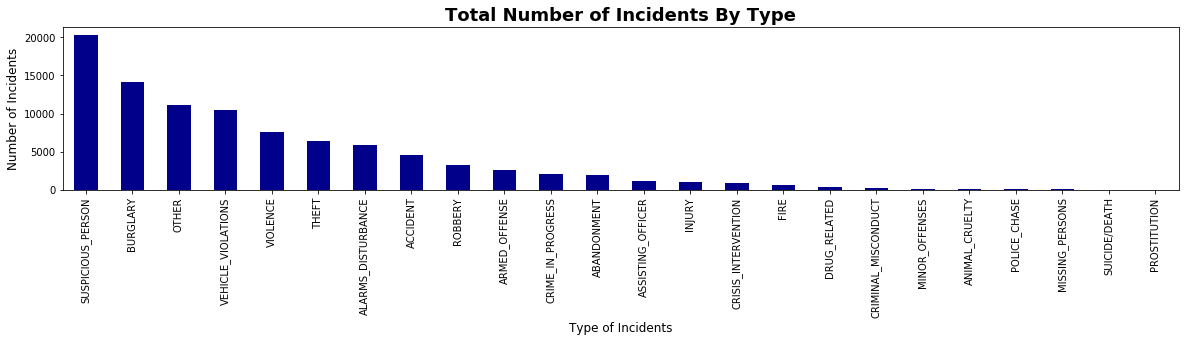

In [24]:
calls.plot(kind="bar", facecolor='darkblue')
plt.title("Total Number of Incidents By Type", fontsize=18, fontweight='bold')
plt.ylabel("Number of Incidents", fontsize=12)
plt.xlabel("Type of Incidents", fontsize=12)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()